In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir /kaggle
! cp kaggle.json /kaggle
! chmod 600 /kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d johnsmith88/heart-disease-dataset
! unzip heart-disease-dataset.zip

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/kaggle’: File exists
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Dataset URL: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset
License(s): unknown
  0% 0.00/6.18k [00:00<?, ?B/s]
100% 6.18k/6.18k [00:00<00:00, 15.3MB/s]
Archive:  heart-disease-dataset.zip
  inflating: heart.csv               


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency, f_oneway, f
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import f_classif


In [3]:
data = pd.read_csv('heart.csv')


In [4]:
# Handle duplicates (if any)
data = data.drop_duplicates()

In [5]:
# Normalize Continuous Features
scaler = StandardScaler()
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
data[continuous_features] = scaler.fit_transform(data[continuous_features])

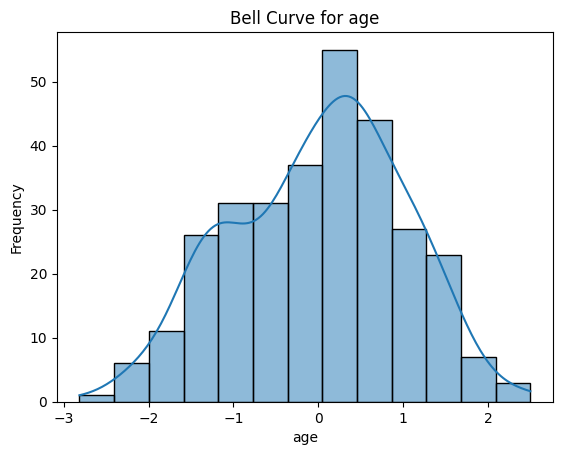

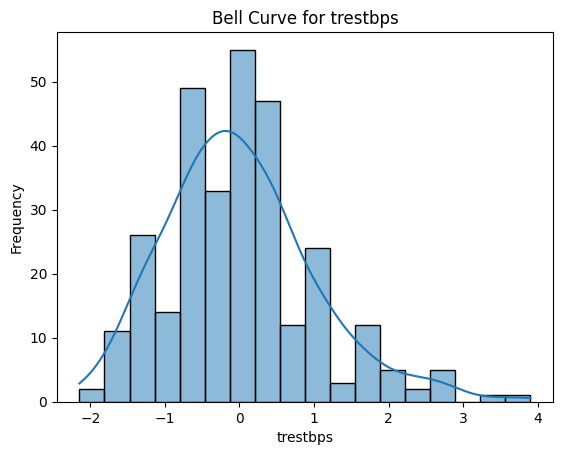

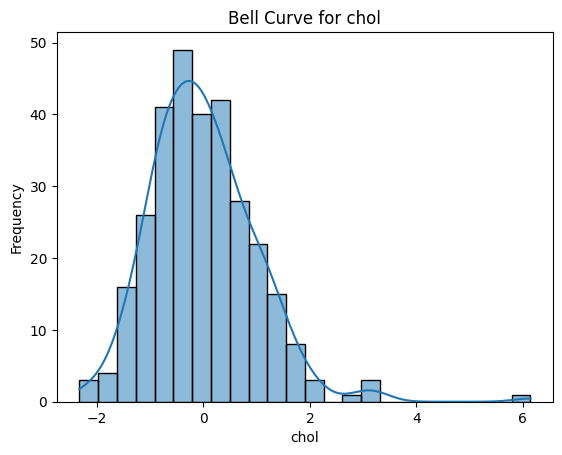

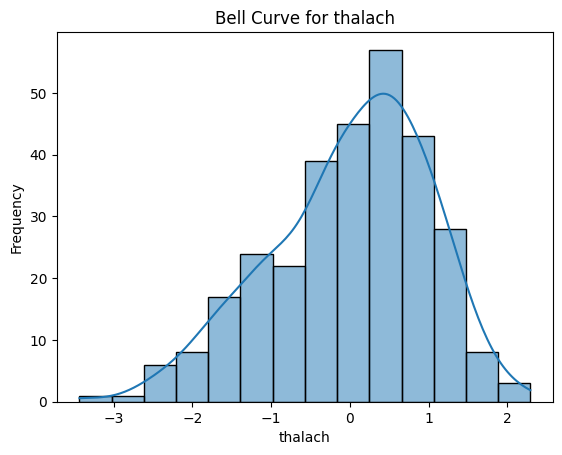

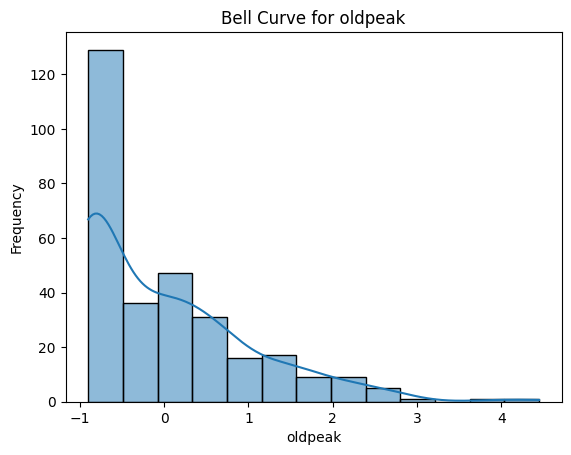

In [6]:
# Empirical Rule & Bell Curve
for col in continuous_features:
    sns.histplot(data[col], kde=True)
    plt.title(f"Bell Curve for {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


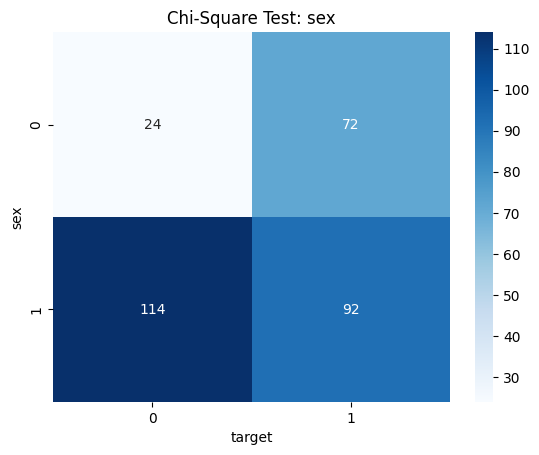

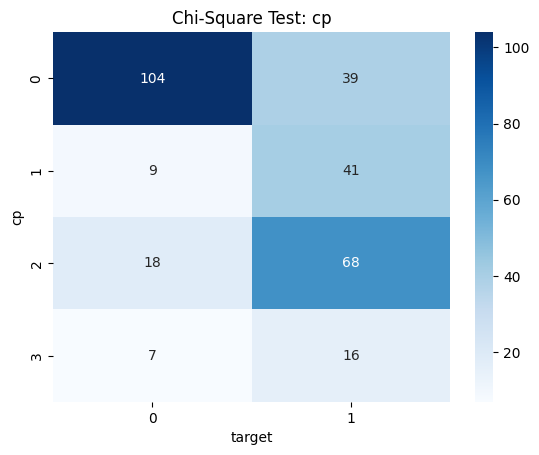

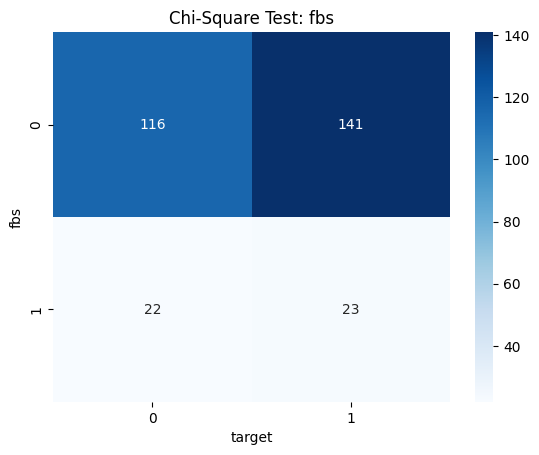

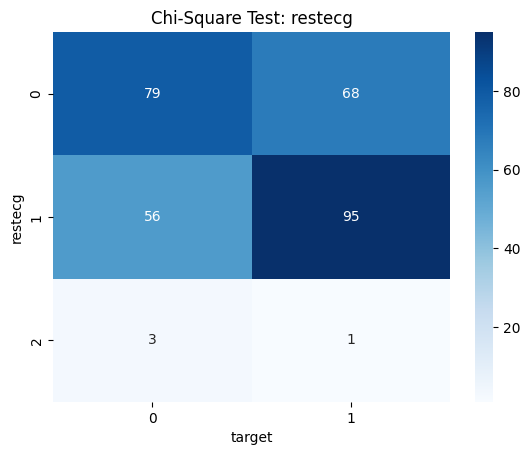

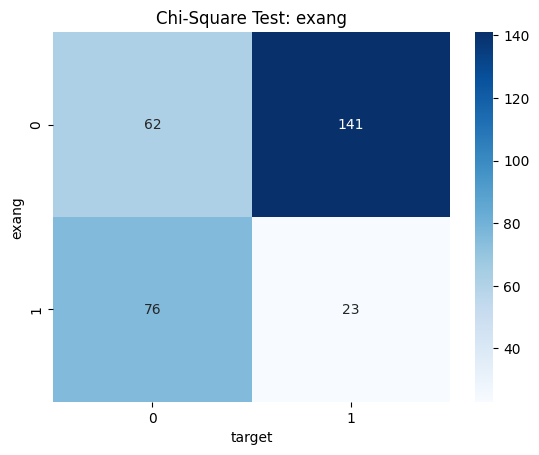

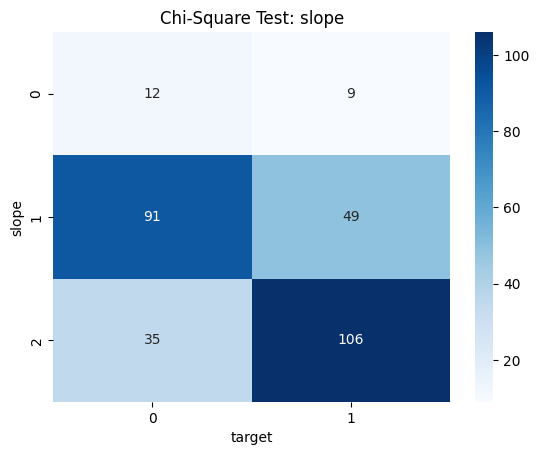

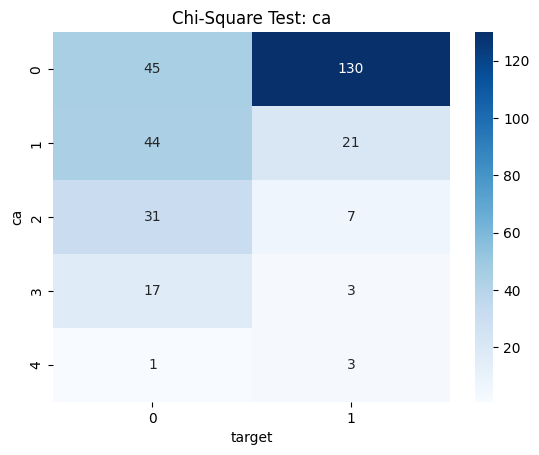

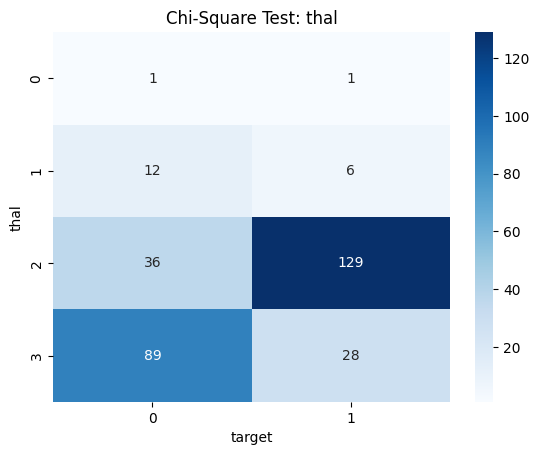


Significant Features (Chi-Square Test): ['sex', 'cp', 'restecg', 'exang', 'slope', 'ca', 'thal']


In [7]:
# Chi-Square Test
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
chi_square_results = {}
for col in categorical_features:
    contingency_table = pd.crosstab(data[col], data['target'])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[col] = (chi2_stat, p_value, dof)

    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Chi-Square Test: {col}")
    plt.show()
    # Print significant features
significant_features = [key for key, (chi2_stat, p_value, dof) in chi_square_results.items() if p_value < 0.05]
print("\nSignificant Features (Chi-Square Test):", significant_features)

ANOVA Test Results for thalach by cp:
F-statistic: 17.6202, Critical Value: 2.6349, P-value: 1.4799e-10



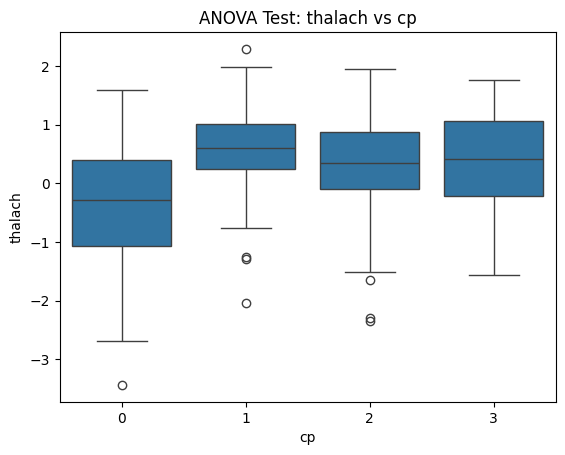

In [8]:
# ANOVA Test
categorical_feature = 'cp'
continuous_feature = 'thalach'
groups = [data[continuous_feature][data[categorical_feature] == category] for category in data[categorical_feature].unique()]
anova_result = f_oneway(*groups)
df_between = len(groups) - 1
df_within = data.shape[0] - len(groups)
critical_value = f.ppf(0.95, df_between, df_within)

print(f"ANOVA Test Results for {continuous_feature} by {categorical_feature}:")
print(f"F-statistic: {anova_result.statistic:.4f}, Critical Value: {critical_value:.4f}, P-value: {anova_result.pvalue:.4e}\n")

sns.boxplot(x=data[categorical_feature], y=data[continuous_feature])
plt.title(f"ANOVA Test: {continuous_feature} vs {categorical_feature}")
plt.show()


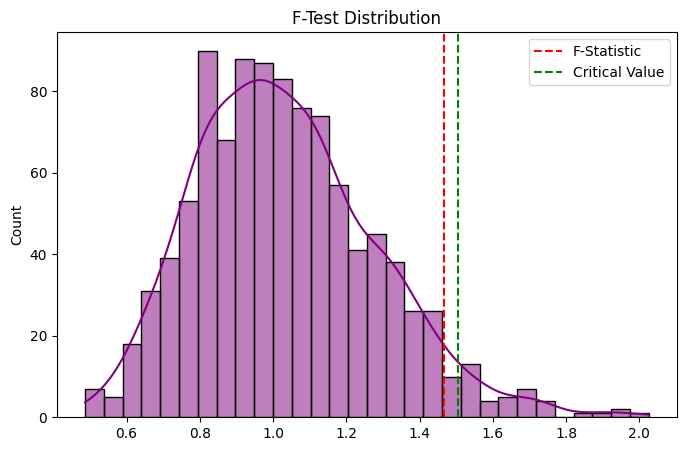

In [9]:
# F-Test for Variance
var_group1 = np.var(groups[0], ddof=1)
var_group2 = np.var(groups[1], ddof=1)
f_stat = var_group1 / var_group2
df1 = len(groups[0]) - 1
df2 = len(groups[1]) - 1
critical_value = f.ppf(0.95, df1, df2)

# F-Test Visualization
plt.figure(figsize=(8, 5))
sns.histplot(np.random.f(df1, df2, 1000), bins=30, kde=True, color='purple')
plt.axvline(f_stat, color='red', linestyle='--', label='F-Statistic')
plt.axvline(critical_value, color='green', linestyle='--', label='Critical Value')
plt.title('F-Test Distribution')
plt.legend()
plt.show()

PCA Reduced Dimensions: 5 components



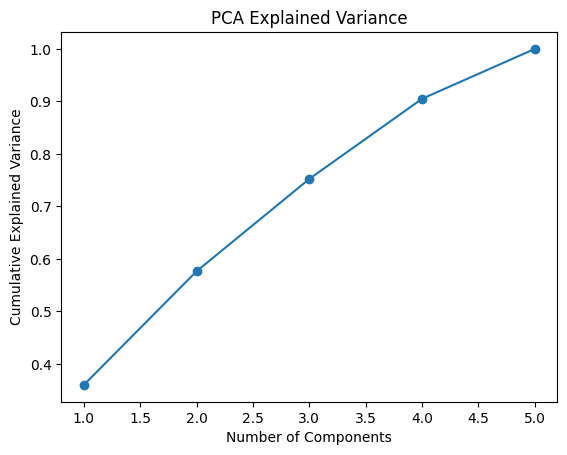

In [10]:
# PCA Analysis
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(data[continuous_features])
pca_variance = pca.explained_variance_ratio_

print(f"PCA Reduced Dimensions: {pca_data.shape[1]} components\n")

plt.plot(range(1, len(pca_variance) + 1), np.cumsum(pca_variance), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()

In [11]:
# Step 7: Feature Importance using Decision Tree
X = data.drop('target', axis=1)
y = data['target']
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y)
feature_importances = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)


In [12]:

# Step 8: Final Feature Selection
final_features = list(set(significant_features + feature_importances.index[:5].tolist()))
print("Final Selected Features:", final_features)


Final Selected Features: ['ca', 'oldpeak', 'chol', 'cp', 'exang', 'thal', 'restecg', 'slope', 'sex']


In [13]:

# Normalize Data using MinMaxScaler
minmax_scaler = MinMaxScaler()
data[continuous_features] = minmax_scaler.fit_transform(data[continuous_features])


In [14]:
print("Preprocessing Completed.")

Preprocessing Completed.


In [15]:
# Encode target variable into binary levels: 0 ('Good') and 1 ('Bad')
def categorize_target(value):
    return 0 if value == 0 else 1

data['target'] = data['target'].apply(categorize_target)

# Encode categorical labels
label_encoder = LabelEncoder()
data['target'] = data['target'].astype(int)


# Split dataset into training and testing
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




In [16]:
# Normalize features (Scaling is crucial for NN performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [17]:
# Define Neural Network Model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Binary classification (0 or 1)
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# Ensure target is integer type
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Evaluate Model
y_pred_prob = model.predict(X_test)

# Ensure correct shape for binary classification
if y_pred_prob.shape[-1] == 1:
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert to 1D array
else:
    y_pred = (y_pred_prob[:, 0] > 0.5).astype(int)  # Select first column if needed




Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.7481 - loss: 0.6297 - val_accuracy: 0.7705 - val_loss: 0.5773
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8321 - loss: 0.5251 - val_accuracy: 0.7705 - val_loss: 0.5286
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8431 - loss: 0.4651 - val_accuracy: 0.7705 - val_loss: 0.5040
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8382 - loss: 0.4345 - val_accuracy: 0.7869 - val_loss: 0.4957
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8291 - loss: 0.4090 - val_accuracy: 0.7869 - val_loss: 0.4889
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8995 - loss: 0.3539 - val_accuracy: 0.7705 - val_loss: 0.4836
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8449 - loss: 0.3949 - val_accuracy: 0.7705 - val_loss: 0.4726
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8542 - loss: 0.3721 - val_accuracy: 0.

In [19]:
# Compute Accuracy in Percentage
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Neural Network Accuracy: {accuracy:.2f}%")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Good (0)', 'Bad (1)']))

Neural Network Accuracy: 81.97%
Classification Report:
              precision    recall  f1-score   support

    Good (0)       0.84      0.75      0.79        28
     Bad (1)       0.81      0.88      0.84        33

    accuracy                           0.82        61
   macro avg       0.82      0.81      0.82        61
weighted avg       0.82      0.82      0.82        61




Confusion Matrix (Raw Format):
[[21  7]
 [ 4 29]]

TP: 29, TN: 21, FP: 7, FN: 4



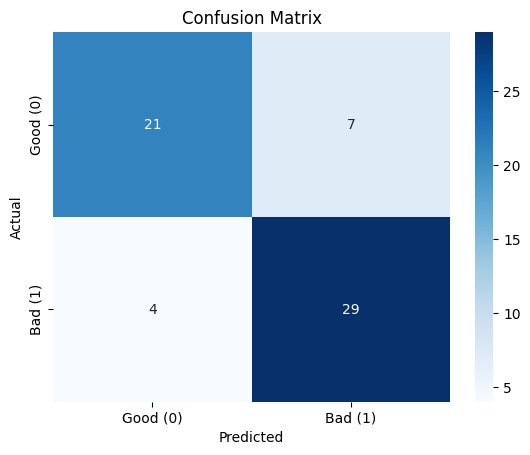

In [20]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

print("\nConfusion Matrix (Raw Format):")
print(conf_matrix)

print(f"\nTP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}\n")

# Heatmap for Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Good (0)', 'Bad (1)'], yticklabels=['Good (0)', 'Bad (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


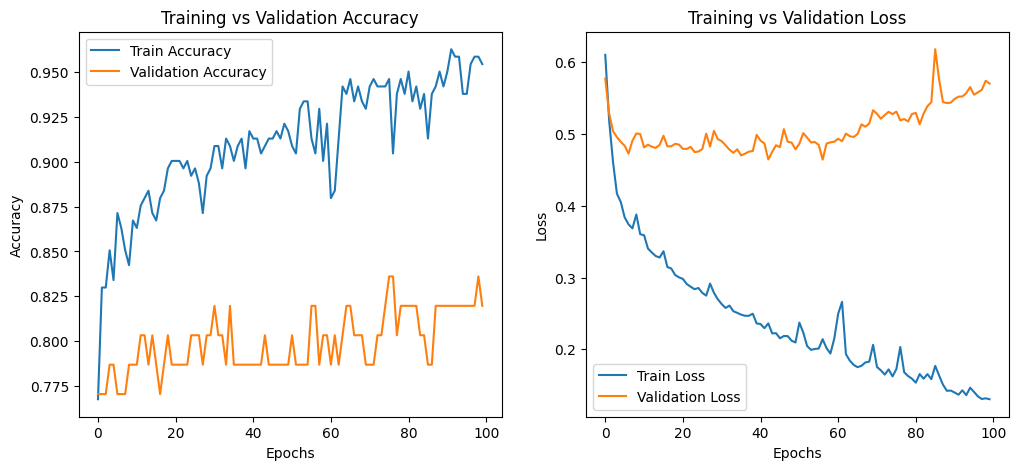

In [21]:

# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()